# Do PCA on data with raw and new features

In [83]:
import numpy as np
import DataProcess as DP
import FeatureCalculate as FC
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [153]:
def preprocess(subjectID, redact=1000, rescale=False):
    subj_filename = './PAMAP2_Dataset/Protocol/subject10'+str(subjectID)+'.dat'
    col_labels = DP.col_labels
    col_sublabels = DP.col_sublabels
    HR_lim = DP.HR_lim
    HR_rest = HR_lim[subjectID][0]
    HR_max = HR_lim[subjectID][1]
    X_std = np.empty(0)
    
    #generate dataframe from the raw data
    data=pd.read_csv(subj_filename,sep=' ',names=col_labels,header=None)

    #linear interpolate missing data
    data=data.interpolate(method='linear')

    #drop columns for orientation and acc6g
    data=pd.DataFrame(data,columns=col_sublabels)

    #convert to array
    data=np.array(data)

    #normalize heart rate
    data[:,2]=DP.HR_norm(data[:,2],HR_rest,HR_max)
    
    #Rescale:
    if rescale:
        SS = StandardScaler(copy=True, with_mean=True, with_std=True)
        data[:, 3:] = SS.fit_transform(data[:, 3:])
        X_std = np.copy(data[:, 3:])
        
    #computes timestamp indices where the activity changes, including 0 and l
    l=len(data)
    r=np.arange(l-1)+1
    split_ind=r[data[r,1]!=data[r-1,1]]
    split_ind=np.concatenate(([0],split_ind,[l]))

    #chop data into chunks of continuous time blocks with the same activity, also remove activity zero
    chunks=[data[split_ind[i]:split_ind[i+1]] for i in range(len(split_ind)-1) if data[split_ind[i],1]!=0]
        
    #drop the first and last n samples. Only keep redacted samples that 
    #are of sufficient length
        
    chunks=[x[redact:-(redact+1)] for x in chunks if len(x) > (2*redact)]

    return X_std, chunks

def segmentation(chunks,T=512,stride=512):
    data_segmented=[]
    for chunk in chunks:
        imax=(len(chunk)-T)//stride
        for i in range(imax+1):
            arr = chunk[i*stride:i*stride+T]
            rawarr = arr[:, 2:].flatten('F')
            farr = feature_extraction(arr)
            totalarr = np.append(rawarr, farr)
            data_segmented.append(totalarr)
    return np.array(data_segmented)

def feature_extraction(segment):
    fc = FC.FeatureCalc()
        
    segment_df=pd.DataFrame(segment,columns=DP.col_sublabels)
    fc.load_new_ts(segment_df)
    arr=fc.calculate_features()
    return arr

### Load + Standardize data:

Standardize each raw feature column of the spectrum (not segment chunks) from each subject individually.

In [154]:
specchunks=[]
for i in [1]:
    X_std, specchunk = preprocess(i, 1000, rescale=True)
    specchunks.append(np.array(specchunk))

### Data segmentation + Feature extraction + Flattening:

In [146]:
chunks=[]
for i in range(len(specchunks)):
    chunks.append(segmentation(specchunks[i],T=400,stride=400))

In [150]:
print("length of one data point should be: 31*(400+4)+1=", 31*(400+4)+1)
print("Shape of chunks from subjects:")
for i in range(len(chunks)):
    print(chunks[i].shape)

length of one data point should be: 31*(400+4)+1= 12525
Shape of chunks from subjects:
(547, 12525)
(581, 12525)
(375, 12525)
(512, 12525)
(606, 12525)
(553, 12525)
(510, 12525)
(579, 12525)
(10, 12525)


### Train-Testing Split:

In [148]:
# Stack data from different subjects into one chunk:
data = np.vstack(chunks)

#shuffle data
np.random.shuffle(data)

X = data[:,:-1]
y = data[:,-1]

In [173]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## PCA

In [151]:
from sklearn.decomposition import PCA

In [193]:
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#print('Eigenvectors:\n', eig_vecs)
print('Eigenvalues:\n', np.abs(eig_vals))

Eigenvalues:
 [  3.46735934e+05   1.69062397e+03   7.26480278e+02 ...,   4.36680459e-17
   1.83449323e-16   1.22004017e-17]


Eigenvalues in descending order:


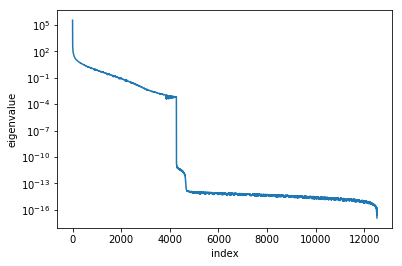

In [192]:
#Make sure the list is sorted by decreasing eigenvalues
#eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
n = len(np.abs(eig_vals))
plt.plot(np.linspace(0, n-1, n), np.abs(eig_vals))
plt.yscale('log')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.show()

### Scree plot

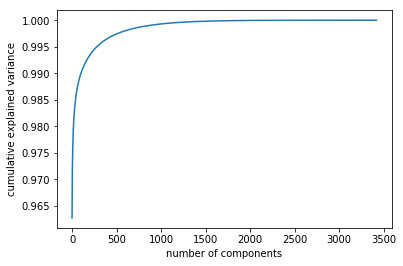

In [178]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Classification:
(Using RandomForestClassifier)

In [202]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#### Keep n_compnents = 50 from PCA:

In [219]:
pca50 = PCA(n_components=50)
X_train50 = pca50.fit_transform(X_train)
X_test50 = pca50.transform(X_test)

cls50=RandomForestClassifier(random_state=42)
cls50.fit(X_train50,y_train)
print('accuracy:', cls50.score(X_test50,y_test))

accuracy: 0.923976608187


#### Keep n_compnents = 100 from PCA:

In [220]:
pca100 = PCA(n_components=100)
X_train100 = pca100.fit_transform(X_train)
X_test100 = pca100.transform(X_test)

cls100=RandomForestClassifier(random_state=42)
cls100.fit(X_train100,y_train)
print('accuracy:', cls100.score(X_test100,y_test))

accuracy: 0.914619883041


In [226]:
train_scores = []
test_scores = []
components = [2,4,6,8,10,15,20,25,50,100,150,200,300,400,600]
for i in components:
    pca = PCA(n_components=i)
    X_tr = pca.fit_transform(X_train)
    X_te = pca.transform(X_test)
    
    cls = RandomForestClassifier(random_state=42)
    cls.fit(X_tr,y_train)
    train_scores.append(cls.score(X_tr,y_train))
    test_scores.append(cls.score(X_te,y_test))

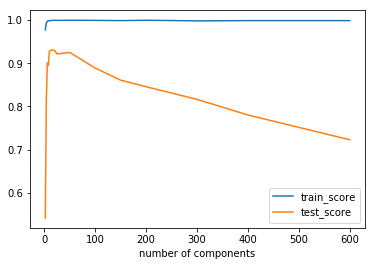

In [227]:
plt.plot(components, train_scores, label='train_score')
plt.plot(components, test_scores, label='test_score')
plt.xlabel('number of components')
plt.legend()
plt.show()

#### Should only keep the number of components < 50, after doing PCA transformation.